In [11]:
import numpy as np
from scipy import stats
#import cupy as cp
import matplotlib.pyplot as plt
import cv2

from lib_MHDPIC1D.pic1d import *
from lib_MHDPIC1D.mhd1d import *
from lib_MHDPIC1D.interface import *
from lib_MHDPIC1D.remove_noise import *

Alfven波の伝搬

interface領域の設定・PIC初期化・MHD初期化 \
一部分をPIC領域にする。粒子の密度と温度はメンドウなので後回し。 \
スタート時に波の節あたりにおけばそこまでひどくならないはず。 \
dx_pic = dx_mhd = 1.0 = $\lambda_{De}$ にする(PICのパラメータで)


In [12]:
dx_pic = 1.0
dx_mhd = 1.0
nx_pic = 200
nx_mhd = 2000
lambda_wave = 1000.0
x_min_pic = 0.0
x_max_pic = nx_pic * dx_pic
x_min_mhd = -lambda_wave
x_max_mhd = x_min_mhd + nx_mhd * dx_mhd
x_coordinate_pic = np.arange(x_min_pic, x_max_pic, dx_pic)
x_coordinate_mhd = np.arange(x_min_mhd, x_max_mhd, dx_mhd)

kx_wave = 2.0 * np.pi / lambda_wave
perturbation_sin = np.sin(kx_wave * x_coordinate_mhd)

window_size_convolution = 10
window_size_smoothing = 10
interface_width = 50

index_interface_mhd_start_left = 1000
index_interface_mhd_end_left = index_interface_mhd_start_left + interface_width
index_interface_mhd_start_right = index_interface_mhd_start_left + nx_pic - interface_width
index_interface_mhd_end_right = index_interface_mhd_start_right + interface_width
index_interface_pic_start_left = 0
index_interface_pic_end_left = interface_width
index_interface_pic_start_right = nx_pic - interface_width
index_interface_pic_end_right = nx_pic

x_interface_coordinate_left = np.arange(0, interface_width, 1)
x_interface_coordinate_half_left = np.arange(0.5, interface_width - 0.5, 1)
F_left = interlocking_function(x_interface_coordinate_left)
F_half_left = interlocking_function(x_interface_coordinate_half_left)
F_right = np.flip(F_left)
F_half_right = np.flip(F_half_left)

In [13]:
c = 1.0
mu_0 = 1.0
epsilon0 = 1.0 / (mu_0 * c**2)
m_electron = 1.0
r_m = 1 / 100
m_ion = m_electron / r_m
t_r = 1.0
ne0_pic = 20 #ここは手動で調整すること
ni0_pic = ne0_pic
B0_pic = np.sqrt(ne0_pic) / 1.0
Te_pic = 0.5 * m_electron * (0.1*c)**2
Ti_pic = Te_pic / t_r
q_electron = -1 * np.sqrt(epsilon0 * Te_pic / ne0_pic)
q_ion = -1 * q_electron
debye_length = np.sqrt(epsilon0 * Te_pic / ne0_pic / q_electron**2)
omega_pe = np.sqrt(ne0_pic * q_electron**2 / m_electron / epsilon0)
omega_pi = np.sqrt(ni0_pic * q_ion**2 / m_ion / epsilon0)
omega_ce = q_electron * B0_pic / m_electron
omega_ci = q_ion * B0_pic / m_ion
VA_pic = B0_pic / np.sqrt(ni0_pic * m_ion + ni0_pic * m_electron)
gamma_pic = 5.0 / 3.0
rho_pic = ni0_pic * m_ion + ne0_pic * m_electron
p_pic = ni0_pic * Ti_pic + ne0_pic * Te_pic
CS_pic = np.sqrt(gamma_pic * p_pic / rho_pic)
v_ion = np.array([0.0, 0.0, 0.0])
v_electron = np.array([0.0, 0.0, 0.0])
v_thermal_electron = np.sqrt(2.0 * Te_pic / m_electron)
v_thermal_ion = np.sqrt(2.0 * Ti_pic / m_ion)
ion_inertial_length = c / omega_pi

In [14]:
gamma_mhd = 5.0 / 3.0
B0_mhd = B0_pic
rho0_mhd = ne0_pic * m_electron + ni0_pic * m_ion
p0_mhd = ne0_pic * Te_pic + ni0_pic * Ti_pic
VA_mhd = B0_mhd / np.sqrt(rho0_mhd)
CS_mhd = np.sqrt(gamma_mhd * p0_mhd / rho0_mhd)
Cf_mhd = np.sqrt(VA_mhd**2 + CS_mhd**2)
dx_mhd = dx_pic

dt_mhd = 0.0
CFL = 0.7

U = np.zeros([8, nx_mhd])
rho_init = rho0_mhd * (1.0 + 0.1 * perturbation_sin)
u_init = 0.1 * Cf_mhd * perturbation_sin
v_init = 0.0
w_init = 0.0
Bx_init = 0.0
By_init = 0.0
Bz_init = B0_mhd * (1.0 + 0.1 * perturbation_sin)
p_init = p0_mhd * (1.0 + gamma_mhd * 0.1 * perturbation_sin)
U[0, :] = rho_init
U[1, :] = rho_init * u_init
U[2, :] = rho_init * v_init
U[3, :] = rho_init * w_init
U[4, :] = Bx_init
U[5, :] = By_init
U[6, :] = Bz_init
U[7, :] = p_init / (gamma_mhd - 1) + rho_init * (u_init**2 + v_init**2 + w_init**2)/2 + (Bx_init**2 + By_init**2 + Bz_init**2)/2

flux = np.zeros(U.shape)
flux_bar = np.zeros(flux.shape)

print(f"U size is {U.shape}")

U size is (8, 2000)


In [15]:
dt_pic = 0.0
d_pic = 0.0

E_pic = np.zeros([3, nx_pic])
B_pic = np.zeros([3, nx_pic])
current_pic = np.zeros([3, nx_pic])
rho_pic = np.zeros(nx_pic)
B_pic[2, :] = B0_pic
beta_pic = (ne0_pic * Te_pic + ni0_pic * Ti_pic) / (B0_pic**2 / 2 / mu_0)

n_ion = int(ni0_pic * nx_pic)
n_electron = int(n_ion * abs(q_ion / q_electron))
x_pic_ion = np.zeros([3, n_ion])
x_pic_electron = np.zeros([3, n_electron])
v_pic_ion = np.zeros([3, n_ion])
v_pic_electron = np.zeros([3, n_electron])

rs_ion = np.random.RandomState(10)
rs_electron = np.random.RandomState(20)
for i in range(nx_pic):
    x_pic_ion[0, i * ni0_pic : (i+1) * ni0_pic] = x_min_pic + (rs_ion.rand(ni0_pic) + i) * dx_pic
    x_pic_electron[0, i * ne0_pic : (i+1) * ne0_pic] = x_min_pic + (rs_electron.rand(ne0_pic) + i) * dx_pic

v_pic_ion[0, :] = np.asarray(stats.norm.rvs(v_ion[0], v_thermal_ion, size=n_ion, random_state=30))
v_pic_ion[1, :] = np.asarray(stats.norm.rvs(v_ion[1], v_thermal_ion, size=n_ion, random_state=40))
v_pic_ion[2, :] = np.asarray(stats.norm.rvs(v_ion[2], v_thermal_ion, size=n_ion, random_state=50))
v_pic_electron[0, :] = np.asarray(stats.norm.rvs(v_electron[0], v_thermal_electron, size=n_electron, random_state=60))
v_pic_electron[1, :] = np.asarray(stats.norm.rvs(v_electron[1], v_thermal_electron, size=n_electron, random_state=70))
v_pic_electron[2, :] = np.asarray(stats.norm.rvs(v_electron[2], v_thermal_electron, size=n_electron, random_state=80))

print(f"total number of particles is {n_ion + n_electron}.")
print(f"Box size is {nx_pic}")
print(f"ion inertial length is {ion_inertial_length:.1f}")

total number of particles is 8000.
Box size is 200
ion inertial length is 141.4


時間発展

In [16]:
#STEP1:PICとMHDの時間を合わせる
#以下、t1からt2に時間発展させるとする
#ただし、t2 = t1 + dt_mhdとする
B_pic_time_ave = np.zeros(B_pic.shape)
zeroth_moment_ion_time_ave = np.zeros(nx_pic)
zeroth_moment_electron_time_ave = np.zeros(nx_pic)
first_moment_ion_time_ave = np.zeros([3, nx_pic])
first_moment_electron_time_ave = np.zeros([3, nx_pic])
second_moment_ion_time_ave = np.zeros([9, nx_pic])
second_moment_electron_time_ave = np.zeros([9, nx_pic])

total_substeps = 10

steps = 10
time_mhd = 0.0
time_pic = 0.0
for step in range(steps+1):

    # save
    if (step % 5 == 0):
        print(f"{step} step done... : time_mhd = {time_mhd:.5f}, time_pic = {time_pic:.5f}, dt_mhd = {dt_mhd:.5f}, dt_pic = {dt_pic:.5f}")
        np.save(f'./results_MH_alfven_periodic/x_ion_{step}.npy', x_pic_ion)
        np.save(f'./results_MH_alfven_periodic/x_electron_{step}.npy', x_pic_electron)
        np.save(f'./results_MH_alfven_periodic/v_ion_{step}.npy', v_pic_ion)
        np.save(f'./results_MH_alfven_periodic/v_electron_{step}.npy', v_pic_electron)
        np.save(f'./results_MH_alfven_periodic/E_{step}.npy', E_pic)
        np.save(f'./results_MH_alfven_periodic/B_{step}.npy', B_pic)
        np.save(f'./results_MH_alfven_periodic/current_{step}.npy', current_pic)
        np.save(f"./results_MH_alfven_periodic/U_{step}.npy", U)

        zeroth_moment_ion = np.zeros(nx_pic)
        zeroth_moment_electron = np.zeros(nx_pic)
        zeroth_moment_ion = get_zeroth_moment(x_pic_ion, nx_pic, dx_pic, zeroth_moment_ion)
        zeroth_moment_electron = get_zeroth_moment(x_pic_electron, nx_pic, dx_pic, zeroth_moment_electron)
        first_moment_ion = np.zeros([3, nx_pic])
        first_moment_electron = np.zeros([3, nx_pic])
        first_moment_ion = get_first_moment(c, v_pic_ion, x_pic_ion, nx_pic, dx_pic, first_moment_ion)
        first_moment_electron = get_first_moment(c, v_pic_electron, x_pic_electron, nx_pic, dx_pic, first_moment_electron)
        second_moment_ion = np.zeros([9, nx_pic])
        second_moment_electron = np.zeros([9, nx_pic])
        second_moment_ion = get_second_moment(c, v_pic_ion, x_pic_ion, nx_pic, dx_pic, second_moment_ion)
        second_moment_electron = get_second_moment(c, v_pic_electron, x_pic_electron, nx_pic, dx_pic, second_moment_electron)

        np.save(f'./results_MH_alfven_periodic/zeroth_moment_ion_{step}.npy', zeroth_moment_ion)
        np.save(f'./results_MH_alfven_periodic/zeroth_moment_electron_{step}.npy', zeroth_moment_electron)
        np.save(f'./results_MH_alfven_periodic/first_moment_ion_{step}.npy', first_moment_ion)
        np.save(f'./results_MH_alfven_periodic/first_moment_electron_{step}.npy', first_moment_electron)
        np.save(f'./results_MH_alfven_periodic/second_moment_ion_{step}.npy', second_moment_ion)
        np.save(f'./results_MH_alfven_periodic/second_moment_electron_{step}.npy', second_moment_electron)

        np.save(f'./results_MH_alfven_periodic/B_time_ave_{step}.npy', B_pic_time_ave)
        np.save(f'./results_MH_alfven_periodic/zeroth_moment_ion_time_ave_{step}.npy', zeroth_moment_ion_time_ave)
        np.save(f'./results_MH_alfven_periodic/zeroth_moment_electron_time_ave_{step}.npy', zeroth_moment_electron_time_ave)
        np.save(f'./results_MH_alfven_periodic/first_moment_ion_time_ave_{step}.npy', first_moment_ion_time_ave)
        np.save(f'./results_MH_alfven_periodic/first_moment_electron_time_ave_{step}.npy', first_moment_electron_time_ave)
        np.save(f'./results_MH_alfven_periodic/second_moment_ion_time_ave_{step}.npy', second_moment_ion_time_ave)
        np.save(f'./results_MH_alfven_periodic/second_moment_electron_time_ave_{step}.npy', second_moment_electron_time_ave)

    #STEP1:MHD-Predictor
    U_past = U.copy()
    #MHD
    #----------------------------------------------------------- 

    U_bar = U.copy()

    rho_mhd = U[0, :]
    u_mhd = U[1, :] / rho_mhd
    v_mhd = U[2, :] / rho_mhd
    w_mhd = U[3, :] / rho_mhd
    Bx_mhd = U[4, :]
    By_mhd = U[5, :]
    Bz_mhd = U[6, :]
    e_mhd = U[7, :]
    p_mhd = (gamma_mhd - 1.0) \
        * (e_mhd - 0.5 * rho_mhd * (u_mhd**2+v_mhd**2+w_mhd**2)
            - 0.5 * (Bx_mhd**2+By_mhd**2+Bz_mhd**2))
    
    # PIC領域のタイムステップは使わない
    # PICのギザギザに支配されるから
    cs_mhd = np.sqrt(gamma_mhd * p_mhd / rho_mhd)
    ca_mhd = np.sqrt((Bx_mhd**2 + By_mhd**2 + Bz_mhd**2) / rho_mhd)
    highest_speed_mhd = (np.abs(u_mhd) + np.sqrt(cs_mhd**2 + ca_mhd**2))
    highest_speed_mhd = np.concatenate([
        highest_speed_mhd[:index_interface_mhd_end_left], 
        highest_speed_mhd[index_interface_mhd_start_right:]
        ])
    dt_mhd = CFL * np.min(1.0 / (highest_speed_mhd / dx_mhd))
    if np.isnan(time_mhd):
        print(f"{step} steps (t = {time_mhd:.3f}) : Calculation is crashed!")
        break
    
    U_bar += -dt_mhd/dx_mhd * (flux - np.roll(flux, 1, axis=1))
    
    rho_mhd = U_bar[0, :]
    u_mhd = U_bar[1, :] / rho_mhd
    v_mhd = U_bar[2, :] / rho_mhd
    w_mhd = U_bar[3, :] / rho_mhd
    Bx_mhd = U_bar[4, :]
    By_mhd = U_bar[5, :]
    Bz_mhd = U_bar[6, :]
    e_mhd = U_bar[7, :]
    p_mhd = (gamma_mhd - 1.0) \
        * (e_mhd - 0.5 * rho_mhd * (u_mhd**2+v_mhd**2+w_mhd**2)
            - 0.5 * (Bx_mhd**2+By_mhd**2+Bz_mhd**2))
    flux_bar = get_flux_HLLD(rho_mhd, u_mhd, v_mhd, w_mhd, Bx_mhd, By_mhd, Bz_mhd, e_mhd, gamma_mhd, flux_bar, axis=0)
    flux = 0.5 * (flux + flux_bar)

    U += -dt_mhd/dx_mhd * (flux - np.roll(flux, 1, axis=1))
        

    #STEP2:PIC
    B_pic_time_ave = np.zeros(B_pic.shape)
    zeroth_moment_ion_time_ave = np.zeros(zeroth_moment_ion_time_ave.shape)
    zeroth_moment_electron_time_ave = np.zeros(zeroth_moment_electron_time_ave.shape)
    first_moment_ion_time_ave = np.zeros(first_moment_ion_time_ave.shape)
    first_moment_electron_time_ave = np.zeros(first_moment_electron_time_ave.shape)
    second_moment_ion_time_ave = np.zeros(second_moment_ion_time_ave.shape)
    second_moment_electron_time_ave = np.zeros(second_moment_electron_time_ave.shape)

    U_send = U_past
    B_pic = send_MHD_to_PICinterface_B(
        index_interface_mhd_start_left, index_interface_mhd_end_left, 
        index_interface_pic_start_left, index_interface_pic_end_left, 
        F_left, F_half_left, 
        U_send, window_size_convolution, B_pic
    )
    E_pic = send_MHD_to_PICinterface_E(
        index_interface_mhd_start_left, index_interface_mhd_end_left, 
        index_interface_pic_start_left, index_interface_pic_end_left, 
        F_left, F_half_left, 
        U_send, window_size_convolution, E_pic
    )
    current_pic = send_MHD_to_PICinterface_current(
        index_interface_mhd_start_left, index_interface_mhd_end_left, 
        index_interface_pic_start_left, index_interface_pic_end_left, 
        F_left, F_half_left, 
        U_send, dx_mhd, window_size_convolution, current_pic
    )
    v_pic_ion, v_pic_electron, x_pic_ion, x_pic_electron = send_MHD_to_PICinterface_particle(
        index_interface_mhd_start_left, index_interface_mhd_end_left, 
        index_interface_pic_start_left, index_interface_pic_end_left, 
        F_left, x_min_pic,  
        U_send, dx_mhd, gamma_mhd, q_electron, 
        m_electron, m_ion, nx_pic, c, window_size_convolution, 
        v_pic_ion, v_pic_electron, x_pic_ion, x_pic_electron
    )
    
    dt_pic = dt_mhd / total_substeps
    for substep in range(total_substeps):

        B_pic = time_evolution_B(E_pic, dx_pic, dt_pic/2, B_pic) 
        B_pic = boundary_B(B_pic)
        U_send = U_past * (total_substeps - (substep + 0.5)) / total_substeps \
                + U * (substep + 0.5) / total_substeps
        B_pic = send_MHD_to_PICinterface_B(
            index_interface_mhd_start_left, index_interface_mhd_end_left, 
            index_interface_pic_start_left, index_interface_pic_end_left, 
            F_left, F_half_left, 
            U_send, window_size_convolution, B_pic
        )
        
        v_pic_ion = time_evolution_v(c, E_pic, B_pic, x_pic_ion, q_ion, m_ion, nx_pic, dx_pic, dt_pic, v_pic_ion)
        v_pic_electron = time_evolution_v(c, E_pic, B_pic, x_pic_electron, q_electron, m_electron, nx_pic, dx_pic, dt_pic, v_pic_electron)
        x_pic_ion = time_evolution_x(c, dt_pic/2, v_pic_ion, x_pic_ion)
        x_pic_electron = time_evolution_x(c, dt_pic/2, v_pic_electron, x_pic_electron)
        #とりあえず
        v_pic_ion, x_pic_ion = open_condition_x_left(v_pic_ion, x_pic_ion, x_min_pic)
        v_pic_ion, x_pic_ion = open_condition_x_right(v_pic_ion, x_pic_ion, x_max_pic)
        v_pic_electron, x_pic_electron = open_condition_x_left(v_pic_electron, x_pic_electron, x_min_pic)
        v_pic_electron, x_pic_electron = open_condition_x_right(v_pic_electron, x_pic_electron, x_max_pic)

        current_pic = np.zeros(current_pic.shape)
        current_pic = get_current_density(c, q_ion, v_pic_ion, x_pic_ion, nx_pic, dx_pic, current_pic)
        current_pic = get_current_density(c, q_electron, v_pic_electron, x_pic_electron, nx_pic, dx_pic, current_pic)
        current_pic[:, 0] = current_pic[:, 1]
        current_pic[:, -1] = current_pic[:, -2]
        U_send = U_past * (total_substeps - (substep + 0.5)) / total_substeps \
                             + U * (substep + 0.5) / total_substeps
        current_pic = send_MHD_to_PICinterface_current(
            index_interface_mhd_start_left, index_interface_mhd_end_left, 
            index_interface_pic_start_left, index_interface_pic_end_left, 
            F_left, F_half_left, 
            U_send, dx_mhd, window_size_convolution, current_pic
        )
        
        B_pic = time_evolution_B(E_pic, dx_pic, dt_pic/2, B_pic)
        B_pic = boundary_B(B_pic)
        U_send = U_past * (total_substeps - (substep + 1.0)) / total_substeps \
                             + U * (substep + 1.0) / total_substeps
        B_pic = send_MHD_to_PICinterface_B(
            index_interface_mhd_start_left, index_interface_mhd_end_left, 
            index_interface_pic_start_left, index_interface_pic_end_left, 
            F_left, F_half_left, 
            U_send, window_size_convolution, B_pic
        )
        
        E_pic = time_evolution_E(B_pic, current_pic, c, epsilon0, dx_pic, dt_pic, E_pic)
        E_pic = boundary_E(E_pic)
        rho_pic = np.zeros(rho_pic.shape)
        rho_pic = get_rho(q_ion, x_pic_ion, nx_pic, dx_pic, rho_pic)
        rho_pic = get_rho(q_electron, x_pic_electron, nx_pic, dx_pic, rho_pic)
        rho_pic[0] = rho_pic[1]
        rho_pic[-1] = rho_pic[-2]
        E_pic = filter_E(rho_pic, dx_pic, dt_pic, d_pic, epsilon0, E_pic)
        U_send = U_past * (total_substeps - (substep + 1.0)) / total_substeps \
                             + U * (substep + 1.0) / total_substeps
        E_pic = send_MHD_to_PICinterface_E(
            index_interface_mhd_start_left, index_interface_mhd_end_left, 
            index_interface_pic_start_left, index_interface_pic_end_left, 
            F_left, F_half_left, 
            U_send, window_size_convolution, E_pic
        )
        
        x_pic_ion = time_evolution_x(c, dt_pic/2, v_pic_ion, x_pic_ion)
        x_pic_electron = time_evolution_x(c, dt_pic/2, v_pic_electron, x_pic_electron)
        #とりあえず
        v_pic_ion, x_pic_ion = open_condition_x_left(v_pic_ion, x_pic_ion, x_min_pic)
        v_pic_ion, x_pic_ion = open_condition_x_right(v_pic_ion, x_pic_ion, x_max_pic)
        v_pic_electron, x_pic_electron = open_condition_x_left(v_pic_electron, x_pic_electron, x_min_pic)
        v_pic_electron, x_pic_electron = open_condition_x_right(v_pic_electron, x_pic_electron, x_max_pic)
        U_send = U_past * (total_substeps - (substep + 1.0)) / total_substeps \
                             + U * (substep + 1.0) / total_substeps
        v_pic_ion, v_pic_electron, x_pic_ion, x_pic_electron = send_MHD_to_PICinterface_particle(
            index_interface_mhd_start_left, index_interface_mhd_end_left, 
            index_interface_pic_start_left, index_interface_pic_end_left, 
            F_left, x_min_pic,  
            U_send, dx_mhd, gamma_mhd, q_electron, 
            m_electron, m_ion, nx_pic, c, window_size_convolution, 
            v_pic_ion, v_pic_electron, x_pic_ion, x_pic_electron
        )

        time_pic += dt_pic


        # 時間平均のため
        B_pic_time_ave += B_pic

        zeroth_moment_ion_tmp = np.zeros(zeroth_moment_ion_time_ave.shape)
        zeroth_moment_electron_tmp = np.zeros(zeroth_moment_electron_time_ave.shape)
        zeroth_moment_ion_tmp = get_zeroth_moment(x_pic_ion, nx_pic, dx_pic, zeroth_moment_ion_tmp)
        zeroth_moment_electron_tmp = get_zeroth_moment(x_pic_electron, nx_pic, dx_pic, zeroth_moment_electron_tmp)
        zeroth_moment_ion_time_ave += zeroth_moment_ion_tmp
        zeroth_moment_electron_time_ave += zeroth_moment_electron_tmp

        first_moment_ion_tmp = np.zeros(first_moment_ion_time_ave.shape)
        first_moment_electron_tmp = np.zeros(first_moment_electron_time_ave.shape)
        first_moment_ion_tmp = get_first_moment(c, v_pic_ion, x_pic_ion, nx_pic, dx_pic, first_moment_ion_tmp)
        first_moment_electron_tmp = get_first_moment(c, v_pic_electron, x_pic_electron, nx_pic, dx_pic, first_moment_electron_tmp)
        first_moment_ion_time_ave += first_moment_ion_tmp
        first_moment_electron_time_ave += first_moment_electron_tmp

        second_moment_ion_tmp = np.zeros(second_moment_ion_time_ave.shape)
        second_moment_electron_tmp = np.zeros(second_moment_electron_time_ave.shape)
        second_moment_ion_tmp = get_second_moment(c, v_pic_ion, x_pic_ion, nx_pic, dx_pic, second_moment_ion_tmp)
        second_moment_electron_tmp = get_second_moment(c, v_pic_electron, x_pic_electron, nx_pic, dx_pic, second_moment_electron_tmp)
        second_moment_ion_time_ave += second_moment_ion_tmp
        second_moment_electron_time_ave += second_moment_electron_tmp
            

    B_pic_time_ave /= total_substeps
    zeroth_moment_ion_time_ave /= total_substeps
    zeroth_moment_electron_time_ave /= total_substeps
    first_moment_ion_time_ave /= total_substeps
    first_moment_electron_time_ave /= total_substeps
    second_moment_ion_time_ave /= total_substeps
    second_moment_electron_time_ave /= total_substeps


    #STEP3:MHD-Correcter
    U_PIC = np.zeros(U.shape)
    #n+1/2にする
    U_PIC[:, :] = 0.5 * (U_past[:, :] + U[:, :])
    U_PIC = send_PIC_to_MHDinterface(
        index_interface_mhd_start_left, index_interface_mhd_end_left, 
        index_interface_pic_start_left, index_interface_pic_end_left, 
        F_left, 
        gamma_mhd, m_electron, m_ion, nx_pic, B_pic_time_ave, 
        zeroth_moment_ion_time_ave, zeroth_moment_electron_time_ave, 
        first_moment_ion_time_ave, first_moment_electron_time_ave, 
        second_moment_ion_time_ave, second_moment_electron_time_ave, 
        window_size_convolution, U_PIC
    )
    
    U = U_past.copy()
    
    rho_mhd = U_PIC[0, :]
    u_mhd = U_PIC[1, :] / rho_mhd
    v_mhd = U_PIC[2, :] / rho_mhd
    w_mhd = U_PIC[3, :] / rho_mhd
    Bx_mhd = U_PIC[4, :]
    By_mhd = U_PIC[5, :]
    Bz_mhd = U_PIC[6, :]
    e_mhd = U_PIC[7, :]
    p_mhd = (gamma_mhd - 1.0) \
        * (e_mhd - 0.5 * rho_mhd * (u_mhd**2+v_mhd**2+w_mhd**2)
            - 0.5 * (Bx_mhd**2+By_mhd**2+Bz_mhd**2))
    flux = get_flux_HLLD(rho_mhd, u_mhd, v_mhd, w_mhd, Bx_mhd, By_mhd, Bz_mhd, e_mhd, gamma_mhd, flux, axis=0)

    U += -dt_mhd/dx_mhd * (flux - np.roll(flux, 1, axis=1))
    
    time_mhd += dt_mhd


    #interface領域のスムージング処理
    U = smoothing_U(
        U, index_interface_mhd_start_left, index_interface_mhd_end_left, 
        window_size_smoothing
    )



0 step done... : time_mhd = 0.00000, time_pic = 0.00000, dt_mhd = 0.00000, dt_pic = 0.00000
5 step done... : time_mhd = 30.37454, time_pic = 30.37454, dt_mhd = 6.07493, dt_pic = 0.60749
10 step done... : time_mhd = 60.74937, time_pic = 60.74937, dt_mhd = 6.07499, dt_pic = 0.60750


プロット

In [17]:
k = 5

B = np.load(f"results_MH_alfven_periodic/B_{k}.npy")
E = np.load(f"results_MH_alfven_periodic/E_{k}.npy")
current = np.load(f"results_MH_alfven_periodic/current_{k}.npy")
x_pic_ion = np.load(f"results_MH_alfven_periodic/x_ion_{k}.npy")
x_pic_electron = np.load(f"results_MH_alfven_periodic/x_electron_{k}.npy")
v_pic_ion = np.load(f"results_MH_alfven_periodic/v_ion_{k}.npy")
v_pic_electron = np.load(f"results_MH_alfven_periodic/v_electron_{k}.npy")
zeroth_moment_ion = np.load(f"results_MH_alfven_periodic/zeroth_moment_ion_{k}.npy")
zeroth_moment_electron = np.load(f"results_MH_alfven_periodic/zeroth_moment_electron_{k}.npy")
first_moment_ion = np.load(f"results_MH_alfven_periodic/first_moment_ion_{k}.npy")
first_moment_electron = np.load(f"results_MH_alfven_periodic/first_moment_electron_{k}.npy")
second_moment_ion = np.load(f"results_MH_alfven_periodic/second_moment_ion_{k}.npy")
second_moment_electron = np.load(f"results_MH_alfven_periodic/second_moment_electron_{k}.npy")

B_time_ave = np.load(f"results_MH_alfven_periodic/B_time_ave_{k}.npy")
zeroth_moment_ion_time_ave = np.load(f"results_MH_alfven_periodic/zeroth_moment_ion_time_ave_{k}.npy")
zeroth_moment_electron_time_ave = np.load(f"results_MH_alfven_periodic/zeroth_moment_electron_time_ave_{k}.npy")
first_moment_ion_time_ave = np.load(f"results_MH_alfven_periodic/first_moment_ion_time_ave_{k}.npy")
first_moment_electron_time_ave = np.load(f"results_MH_alfven_periodic/first_moment_electron_time_ave_{k}.npy")
second_moment_ion_time_ave = np.load(f"results_MH_alfven_periodic/second_moment_ion_time_ave_{k}.npy")
second_moment_electron_time_ave = np.load(f"results_MH_alfven_periodic/second_moment_electron_time_ave_{k}.npy")

U = np.load(f"results_MH_alfven_periodic/U_{k}.npy")
rho_mhd = U[0, :]
u_mhd = U[1, :] / rho_mhd
v_mhd = U[2, :] / rho_mhd
w_mhd = U[3, :] / rho_mhd
Bx_mhd = U[4, :]
By_mhd = U[5, :]
Bz_mhd = U[6, :]
e_mhd = U[7, :]
p_mhd = (gamma_mhd - 1.0) \
        * (e_mhd - 0.5 * rho_mhd * (u_mhd**2+v_mhd**2+w_mhd**2)
            - 0.5 * (Bx_mhd**2+By_mhd**2+Bz_mhd**2))
Ex_mhd = -(v_mhd * Bz_mhd - w_mhd * By_mhd)
Ey_mhd = -(w_mhd * Bx_mhd - u_mhd * Bz_mhd)
Ez_mhd = -(u_mhd * By_mhd - v_mhd * Bx_mhd)
current_x_mhd = np.zeros(Bx_mhd.shape)
current_y_mhd = -(np.roll(Bz_mhd, -1, axis=0) - np.roll(Bz_mhd, 1, axis=0)) / (2*dx_mhd)
current_z_mhd = (np.roll(By_mhd, -1, axis=0) - np.roll(By_mhd, 1, axis=0)) / (2*dx_mhd)
current_y_mhd[0] = current_y_mhd[1] 
current_y_mhd[-1] = current_y_mhd[-2] 
current_z_mhd[0] = current_z_mhd[1] 
current_z_mhd[-1] = current_z_mhd[-2] 

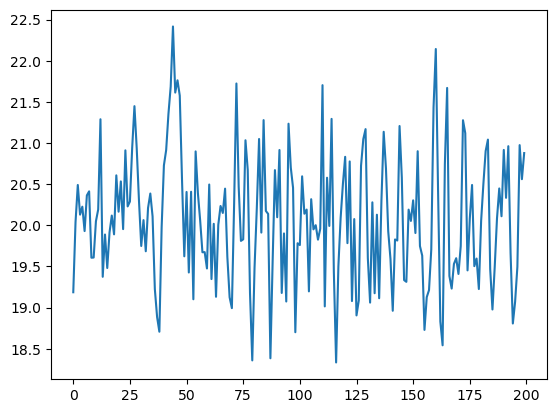

In [18]:
#plt.plot(B[2, :])
plt.plot(convolve_parameter(zeroth_moment_ion, 3))

4013 3988


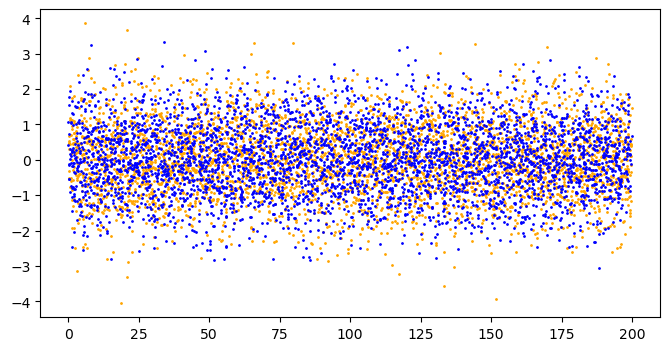

In [19]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(111)

plt.scatter(x_pic_ion[0, :], v_pic_ion[1, :] / v_thermal_ion, s=1, color='orange')
plt.scatter(x_pic_electron[0, :], v_pic_electron[1, :] / v_thermal_electron, s=1, color='blue')
#plt.ylim(-10, 10)
#plt.xlim(30, 70)
print(x_pic_ion.shape[1], x_pic_electron.shape[1])

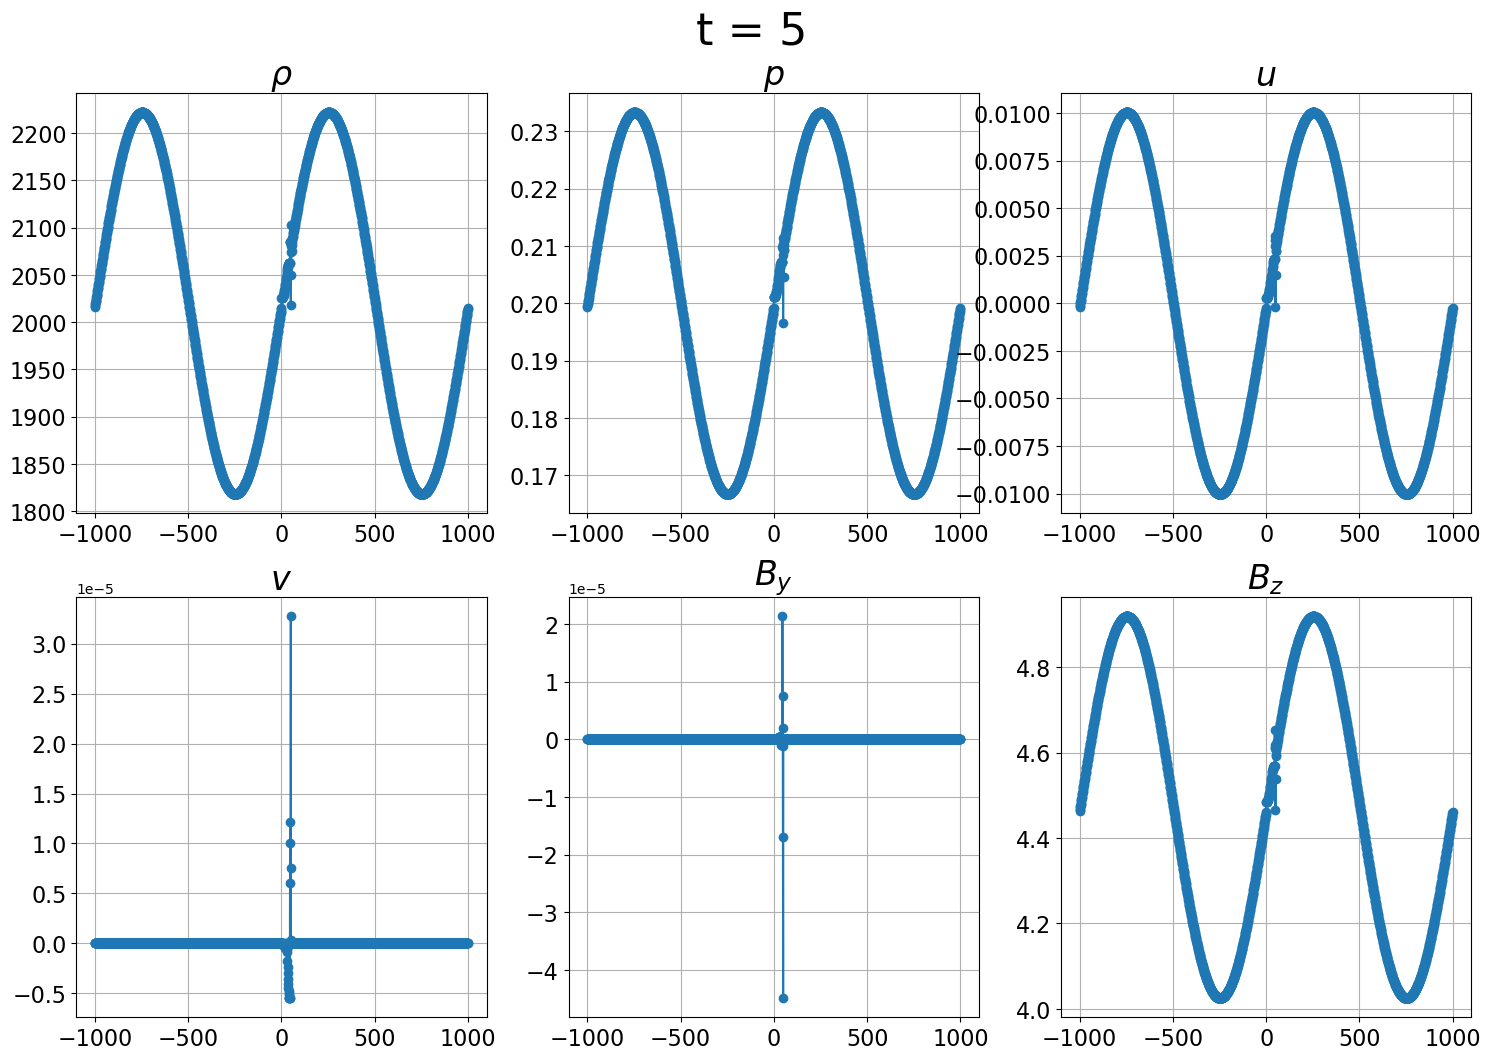

In [20]:
fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

rho = U[0, :]
u = U[1, :] / rho 
v = U[2, :] / rho 
w = U[3, :] / rho 
Bx = U[4, :]
By = U[5, :]
Bz = U[6, :]
e = U[7, :]
p = (gamma_mhd-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

ax1.plot(x_coordinate_mhd, rho, marker='o')
ax2.plot(x_coordinate_mhd, p, marker='o')
ax3.plot(x_coordinate_mhd, u, marker='o')
ax4.plot(x_coordinate_mhd, v, marker='o')
ax5.plot(x_coordinate_mhd, By, marker='o')
ax6.plot(x_coordinate_mhd, Bz, marker='o')

ax1.set_title(r"$\rho$", fontsize=24)
ax2.set_title(r"$p$", fontsize=24)
ax3.set_title(r"$u$", fontsize=24)
ax4.set_title(r"$v$", fontsize=24)
ax5.set_title(r"$B_y$", fontsize=24)
ax6.set_title(r"$B_z$", fontsize=24)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)
ax5.tick_params(labelsize=16)
ax6.tick_params(labelsize=16)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

plt.suptitle(f"t = {k}", y=0.95, fontsize=32)

plt.show()

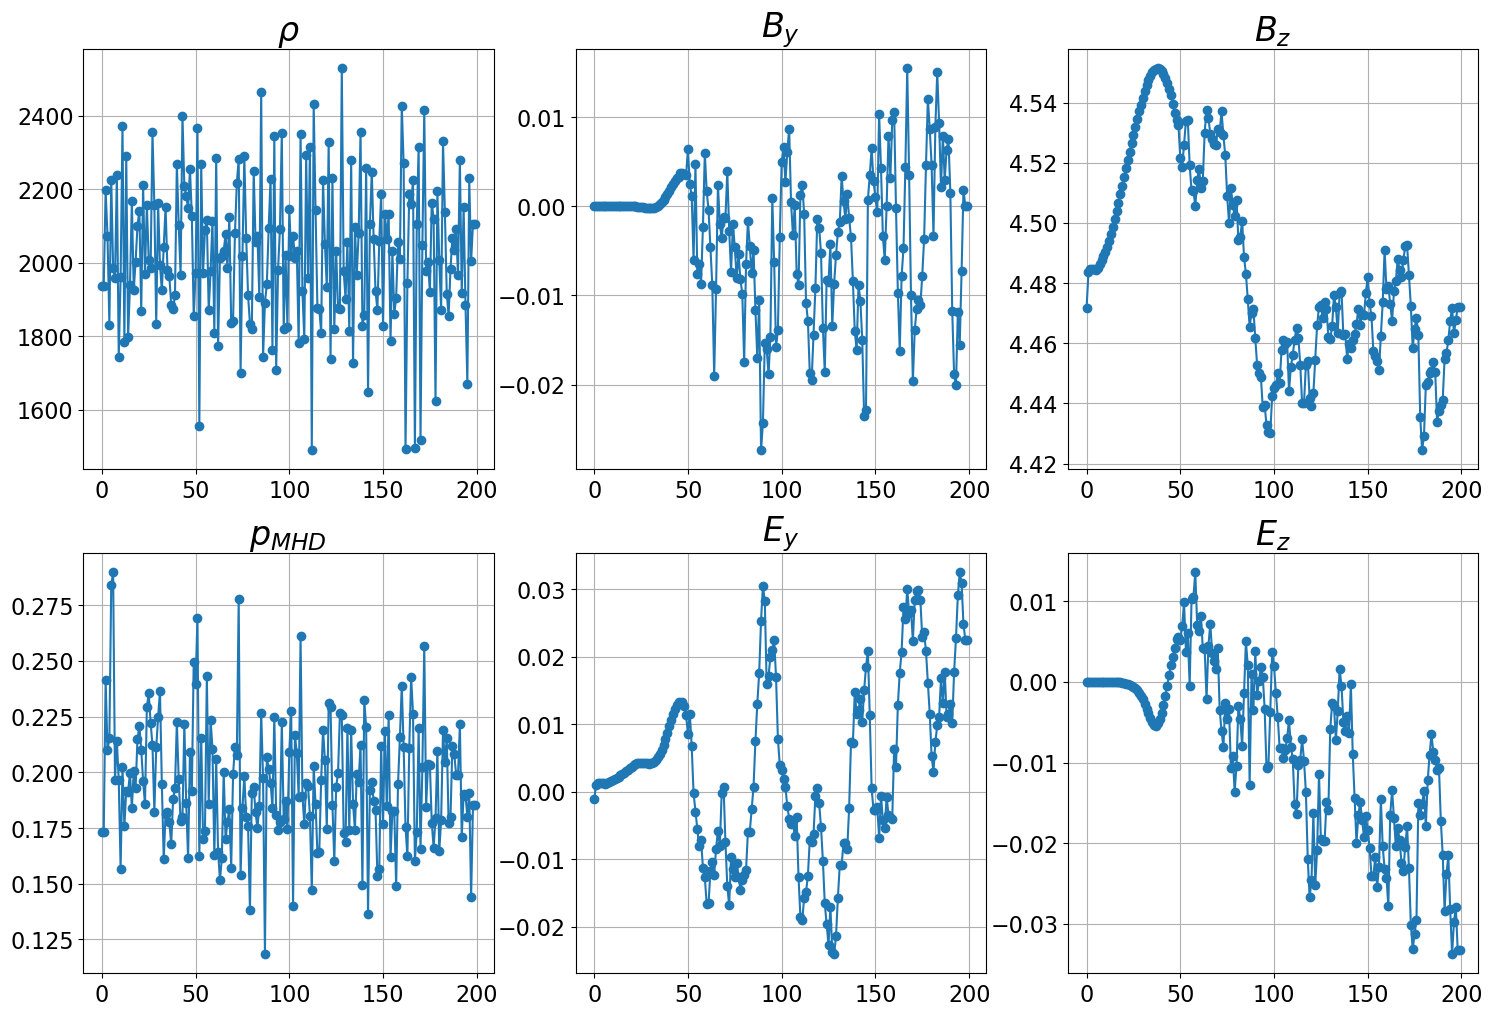

In [21]:
fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

rho_pic = m_electron * zeroth_moment_electron + m_ion * zeroth_moment_ion
bulk_speed_ion_pic = first_moment_ion / (zeroth_moment_ion + 1e-10)
bulk_speed_electron_pic = first_moment_electron / (zeroth_moment_electron + 1e-10)
bulk_speed_pic = (m_electron * bulk_speed_electron_pic + m_ion * bulk_speed_ion_pic) / (m_electron + m_ion)
v_thi_squared_pic = ((second_moment_ion[0, :] + second_moment_ion[4, :] + second_moment_ion[8, :])
                      - zeroth_moment_ion * (bulk_speed_ion_pic[0, :]**2 + bulk_speed_ion_pic[1, :]**2 + bulk_speed_ion_pic[2, :]**2)) \
                      / 3.0 / (zeroth_moment_ion + 1e-10)
v_the_squared_pic = ((second_moment_electron[0, :] + second_moment_electron[4, :] + second_moment_electron[8, :])
                     - zeroth_moment_electron * (bulk_speed_electron_pic[0, :]**2 + bulk_speed_electron_pic[1, :]**2 + bulk_speed_electron_pic[2, :]**2)) \
                      / 3.0 / (zeroth_moment_electron + 1e-10)
p_pic = zeroth_moment_electron * m_electron * v_the_squared_pic / 2.0 + zeroth_moment_ion * m_ion * v_thi_squared_pic / 2.0
p_mhd = p_pic

ax1.plot(x_coordinate_pic, rho_pic, marker='o')
ax2.plot(x_coordinate_pic, B[1, :], marker='o')
ax3.plot(x_coordinate_pic, B[2, :], marker='o')
ax4.plot(x_coordinate_pic, p_mhd, marker='o')
ax5.plot(x_coordinate_pic, E[1, :], marker='o')
ax6.plot(x_coordinate_pic, E[2, :], marker='o')

ax1.set_title(r"$\rho$", fontsize=24)
ax2.set_title(r"$B_y$", fontsize=24)
ax3.set_title(r"$B_z$", fontsize=24)
ax4.set_title(r"$p_{MHD}$", fontsize=24)
ax5.set_title(r"$E_y$", fontsize=24)
ax6.set_title(r"$E_z$", fontsize=24)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)
ax5.tick_params(labelsize=16)
ax6.tick_params(labelsize=16)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

plt.show()

動画作成

FileNotFoundError: [Errno 2] No such file or directory: 'results_MH_alfven_periodic/U1_0.npy'

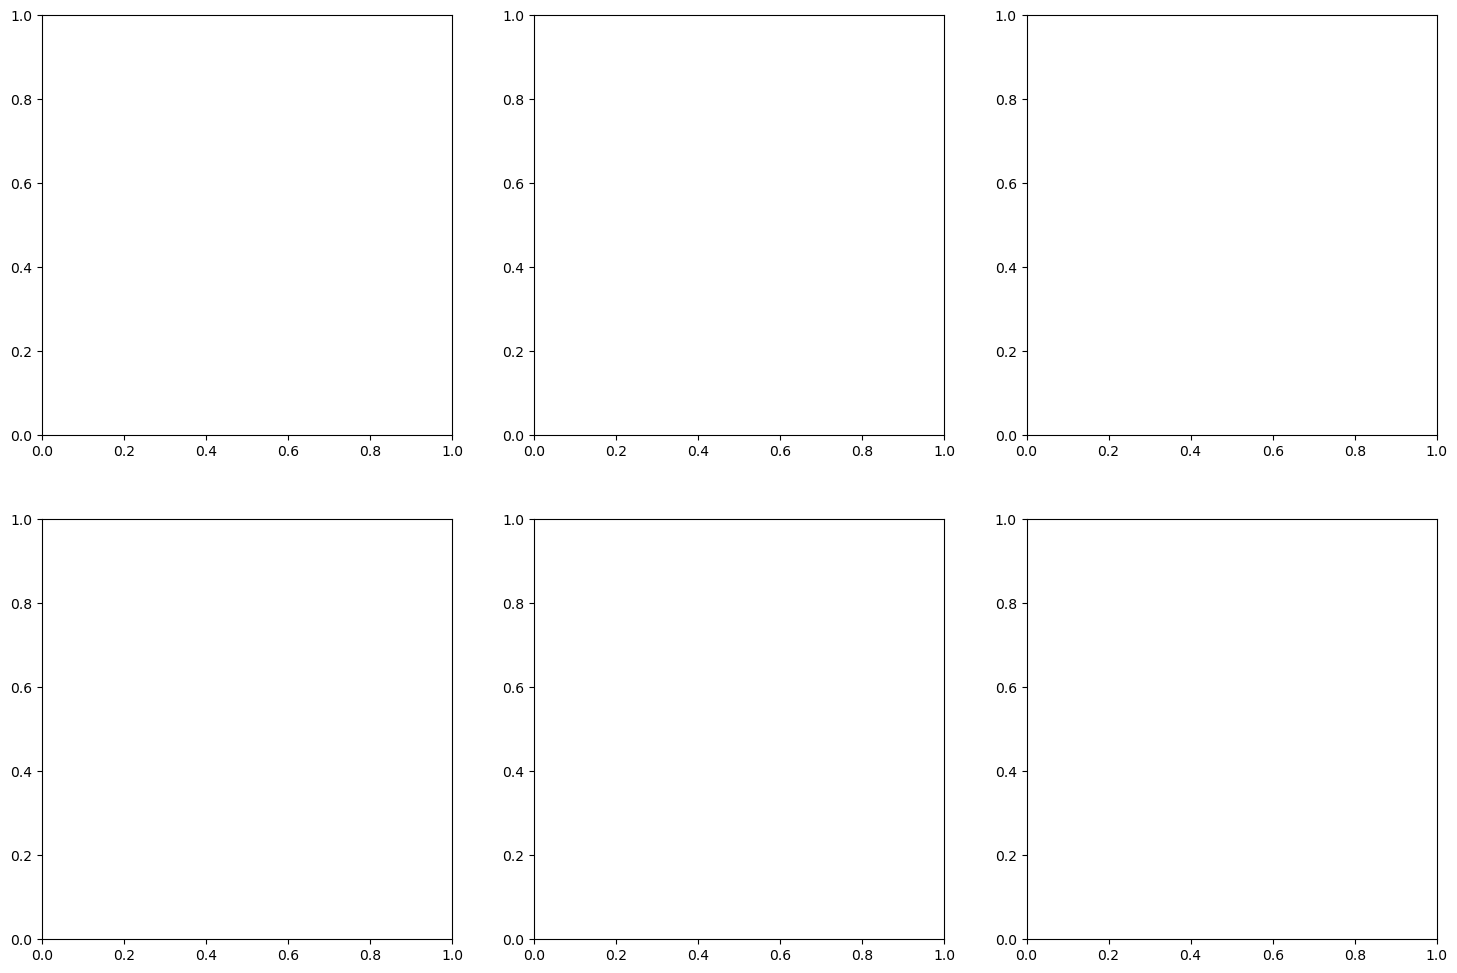

In [22]:
fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

filename = "Alfven_MHD-PIC_periodic_MHD.mp4"

interval = 5
plot_steps = steps
for i in range(0, plot_steps+1, interval):
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()
    ax5.clear()
    ax6.clear()

    U = np.load(f"results_MH_alfven_periodic/U1_{i}.npy")
    rho = U[0, :]
    u = U[1, :] / rho 
    v = U[2, :] / rho 
    w = U[3, :] / rho 
    Bx = U[4, :]
    By = U[5, :]
    Bz = U[6, :]
    e = U[7, :]
    p = (gamma_mhd-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

    ax1.plot(x_coordinate_mhd, rho / rho0_mhd, marker='o')
    ax2.plot(x_coordinate_mhd, p / p0_mhd, marker='o')
    ax3.plot(x_coordinate_mhd, u, marker='o')
    ax4.plot(x_coordinate_mhd, v, marker='o')
    ax5.plot(x_coordinate_mhd, By / B0_mhd, marker='o')
    ax6.plot(x_coordinate_mhd, Bz / B0_mhd, marker='o')

    ax1.set_ylim(0.5, 1.5)
    ax2.set_ylim(0.5, 2.0)
    ax3.set_ylim(-0.1, 0.1)
    ax4.set_ylim(-0.3, 0.3)
    ax5.set_ylim(-0.1, 0.1)
    ax6.set_ylim(0.8, 1.2)

    ax1.set_title(r"$\rho$", fontsize=24)
    ax2.set_title(r"$p$", fontsize=24)
    ax3.set_title(r"$u$", fontsize=24)
    ax4.set_title(r"$v$", fontsize=24)
    ax5.set_title(r"$B_y$", fontsize=24)
    ax6.set_title(r"$B_z$", fontsize=24)
    ax1.tick_params(labelsize=16)
    ax2.tick_params(labelsize=16)
    ax3.tick_params(labelsize=16)
    ax4.tick_params(labelsize=16)
    ax5.tick_params(labelsize=16)
    ax6.tick_params(labelsize=16)
    ax1.grid()
    ax2.grid()
    ax3.grid()
    ax4.grid()
    ax5.grid()
    ax6.grid()

    plt.suptitle(f"t = {i}", y=0.95, fontsize=32)

    fig.savefig(f'./pictures/{i}.png', dpi=200)


img = cv2.imread(f'./pictures/0.png')
framesize = (img.shape[1], img.shape[0])
fps = 5.0

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename, fourcc=fourcc, fps=fps, frameSize=framesize)

for i in range(0, plot_steps+1, interval):
    img = cv2.imread(f'./pictures/{i}.png')
    video.write(img)
video.release()

In [ ]:
fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

filename = "Alfven_MHD-PIC_periodic_PIC.mp4"

interval = 5
plot_steps = steps
for i in range(0, plot_steps+1, interval):
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()
    ax5.clear()
    ax6.clear()

    B = np.load(f"results_MH_alfven_periodic/B_{i}.npy")
    E = np.load(f"results_MH_alfven_periodic/E_{i}.npy")
    x_pic_ion = np.load(f"results_MH_alfven_periodic/x_ion_{i}.npy")
    x_pic_electron = np.load(f"results_MH_alfven_periodic/x_electron_{i}.npy")
    v_pic_ion = np.load(f"results_MH_alfven_periodic/v_ion_{i}.npy")
    v_pic_electron = np.load(f"results_MH_alfven_periodic/v_electron_{i}.npy")

    zeroth_moment_ion = np.zeros(nx_pic)
    zeroth_moment_electron = np.zeros(nx_pic)
    zeroth_moment_ion = get_zeroth_moment(x_pic_ion, nx_pic, dx_pic, zeroth_moment_ion)
    zeroth_moment_electron = get_zeroth_moment(x_pic_electron, nx_pic, dx_pic, zeroth_moment_electron)
    first_moment_ion = np.zeros([3, nx_pic])
    first_moment_electron = np.zeros([3, nx_pic])
    first_moment_ion = get_first_moment(c, v_pic_ion, x_pic_ion, nx_pic, dx_pic, first_moment_ion)
    first_moment_electron = get_first_moment(c, v_pic_electron, x_pic_electron, nx_pic, dx_pic, first_moment_electron)
    second_moment_ion = np.zeros([9, nx_pic])
    second_moment_electron = np.zeros([9, nx_pic])
    second_moment_ion = get_second_moment(c, v_pic_ion, x_pic_ion, nx_pic, dx_pic, second_moment_ion)
    second_moment_electron = get_second_moment(c, v_pic_electron, x_pic_electron, nx_pic, dx_pic, second_moment_electron)

    rho_pic = m_electron * zeroth_moment_electron + m_ion * zeroth_moment_ion
    bulk_speed_ion_pic = first_moment_ion / (zeroth_moment_ion + 1e-10)
    bulk_speed_electron_pic = first_moment_electron / (zeroth_moment_electron + 1e-10)
    bulk_speed_pic = (m_electron * bulk_speed_electron_pic + m_ion * bulk_speed_ion_pic) / (m_electron + m_ion)
    v_thi_squared_pic = ((second_moment_ion[0, :] + second_moment_ion[4, :] + second_moment_ion[8, :])
                      - zeroth_moment_ion * (bulk_speed_ion_pic[0, :]**2 + bulk_speed_ion_pic[1, :]**2 + bulk_speed_ion_pic[2, :]**2)) \
                      / 3.0 / (zeroth_moment_ion + 1e-10)
    v_the_squared_pic = ((second_moment_electron[0, :] + second_moment_electron[4, :] + second_moment_electron[8, :])
                      - zeroth_moment_electron * (bulk_speed_electron_pic[0, :]**2 + bulk_speed_electron_pic[1, :]**2 + bulk_speed_electron_pic[2, :]**2)) \
                      / 3.0 / (zeroth_moment_electron + 1e-10)

    p_pic = zeroth_moment_electron * m_electron * v_the_squared_pic / 2.0 + zeroth_moment_ion * m_ion * v_thi_squared_pic / 2.0
    p_mhd = p_pic

    ax1.plot(x_coordinate_pic, rho_pic / rho0_mhd, marker='o')
    ax2.plot(x_coordinate_pic, B[1, :] / B0_pic, marker='o')
    ax3.plot(x_coordinate_pic, B[2, :] / B0_pic, marker='o')
    ax4.plot(x_coordinate_pic, p_mhd / p0_mhd, marker='o')
    ax5.plot(x_coordinate_pic, E[1, :], marker='o')
    ax6.plot(x_coordinate_pic, E[2, :], marker='o')

    ax1.set_ylim(0.5, 1.5)
    ax2.set_ylim(-0.2, 0.2)
    ax3.set_ylim(0.8, 1.2)
    ax4.set_ylim(0.5, 2.0)
    ax5.set_ylim(-0.2, 0.2)
    ax6.set_ylim(-0.2, 0.2)

    ax1.set_title(r"$\rho$", fontsize=24)
    ax2.set_title(r"$B_y$", fontsize=24)
    ax3.set_title(r"$B_z$", fontsize=24)
    ax4.set_title(r"$p_{MHD}$", fontsize=24)
    ax5.set_title(r"$E_y$", fontsize=24)
    ax6.set_title(r"$E_z$", fontsize=24)
    ax1.tick_params(labelsize=16)
    ax2.tick_params(labelsize=16)
    ax3.tick_params(labelsize=16)
    ax4.tick_params(labelsize=16)
    ax5.tick_params(labelsize=16)
    ax6.tick_params(labelsize=16)
    ax1.grid()
    ax2.grid()
    ax3.grid()
    ax4.grid()
    ax5.grid()
    ax6.grid()

    plt.suptitle(f"t = {i}", y=0.95, fontsize=32)

    fig.savefig(f'./pictures/{i}.png', dpi=200)


img = cv2.imread(f'./pictures/0.png')
framesize = (img.shape[1], img.shape[0])
fps = 5.0

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename, fourcc=fourcc, fps=fps, frameSize=framesize)

for i in range(0, plot_steps+1, interval):
    img = cv2.imread(f'./pictures/{i}.png')
    video.write(img)
video.release()